# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs.

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. hwutils.py) so they can be commented on easily and focus the notebook on plotting. Also see the workshop on Clean Code from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.

In [4]:
# useful libraries to import
import sklearn
import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

import seaborn as sns; sns.set()

# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

##hwutils is a separate script where we can put helper functions
#from hwutils2 import *

In [5]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('data/ENCODE_GRCh38_binned_subset.tsv')
#df = pd.read_table('/Users/fouerghi20/Desktop/qbio577_fall2022/data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('data/ENCODE_GRCh38_bigWig_metadata.tsv')
#bigwig_metadata = pd.read_table('/Users/fouerghi20/Desktop/qbio577_fall2022/data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/11/j6b5zsfd6tj5t9y4zw9d0wth0000gn/T/ipykernel_1664/3047297112.py:8: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('data/ENCODE_GRCh38_bigWig_metadata.tsv')


### 1. After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?

Text(0, 0.5, 'ENCFF230YBR')

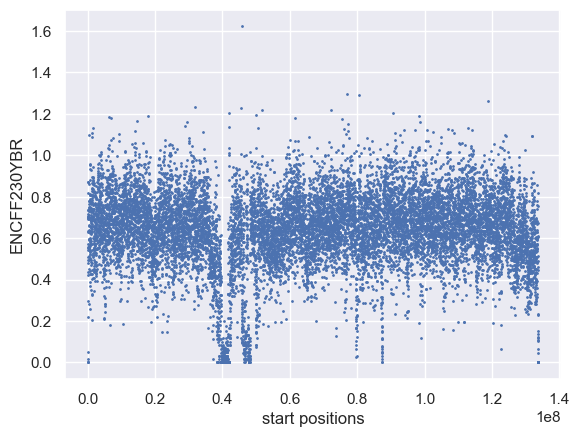

In [6]:
##visualize some of the profiles
#1
plt.scatter(df['start'], df['ENCFF230YBR'], s=1)
plt.xlabel('start positions')
plt.ylabel('ENCFF230YBR')

Text(0, 0.5, 'ENCFF953CVO')

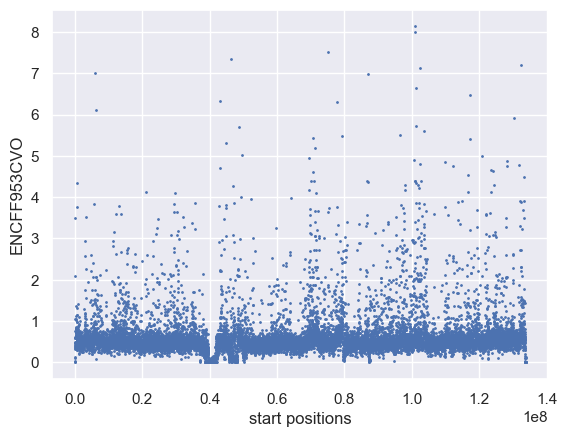

In [7]:
#2
plt.scatter(df['start'], df['ENCFF953CVO'], s=1)
plt.xlabel('start positions')
plt.ylabel('ENCFF953CVO')

The signals dropping indicates that there is no binding site of DNA-associated proteins. In this case, one possibility is that the centromere is located at around 40Mb since centromeres are not included in the traditional reference genome assembly. However, it is known now that the centromere of chr10 is located at 39.8Mbp. Thus, this fact further shows that many signals dip on chr10 at around 40Mb because they are at the centromere of chr10.

### 2. Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.

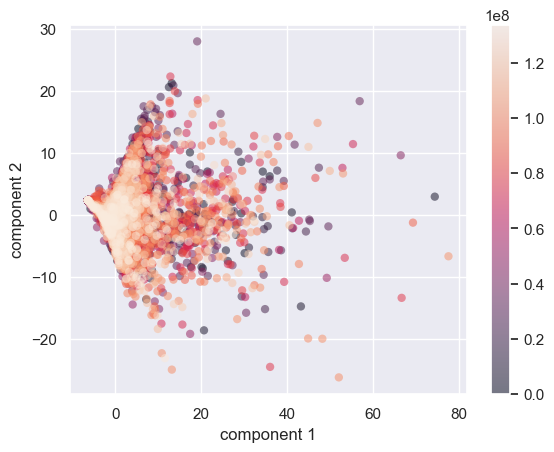

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df2 = df.drop(['chrom','start','end'],axis=1) 
pca.fit(df2)
df2_pca = pca.transform(df2)

plt.scatter(df2_pca[:, 0], df2_pca[:, 1],
            c=df.start, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### 3. Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that sklearn.preprocessing.LabelEncoder() can be useful for transforming text strings to categories, and plt.text can be used to overlay labels with points.

In [11]:
import matplotlib.patches as mpatches

def plot_pca( pca , 
             bigwig_metadata=None,
             metadata_label_column=None, 
             alpha=0.5, 
             lw=0, 
             figsize=(8,8)):
    
    """ 
    Skeleton for plotting PCA and annotating the plot. 
    Can be modified/extended to answer various questions.
    """
    
    
    if metadata_label_column is not None:
        if bigwig_metadata is None: 
            raise ValueError("must provide metadata table to label by a metadata column") 
        labels = [bigwig_metadata.query(
                    "`File accession`==@ file_accession ").loc[:,metadata_label_column].values[0]
                  for file_accession in pca.feature_names_in_]
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(labels)
        labels = le.transform(labels)
    else: 
        labels = None
    

    new_labels = le.inverse_transform(labels)
    plt.figure(figsize=figsize)
    c = np.random.rand(5)
    scatter = plt.scatter(pca.components_[0],
                pca.components_[1],
                c = labels,
                cmap = 'Spectral',
                alpha=alpha,
                lw=lw
   )
    classes=np.unique(new_labels).tolist()
#    plt.legend(handles=scatter.legend_elements()[0],labels=classes,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(handles=scatter.legend_elements(num=len(classes))[0], labels=classes,loc='center left', bbox_to_anchor=(1, 0.5))
#    for i, txt in enumerate(new_labels):
#        plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]))

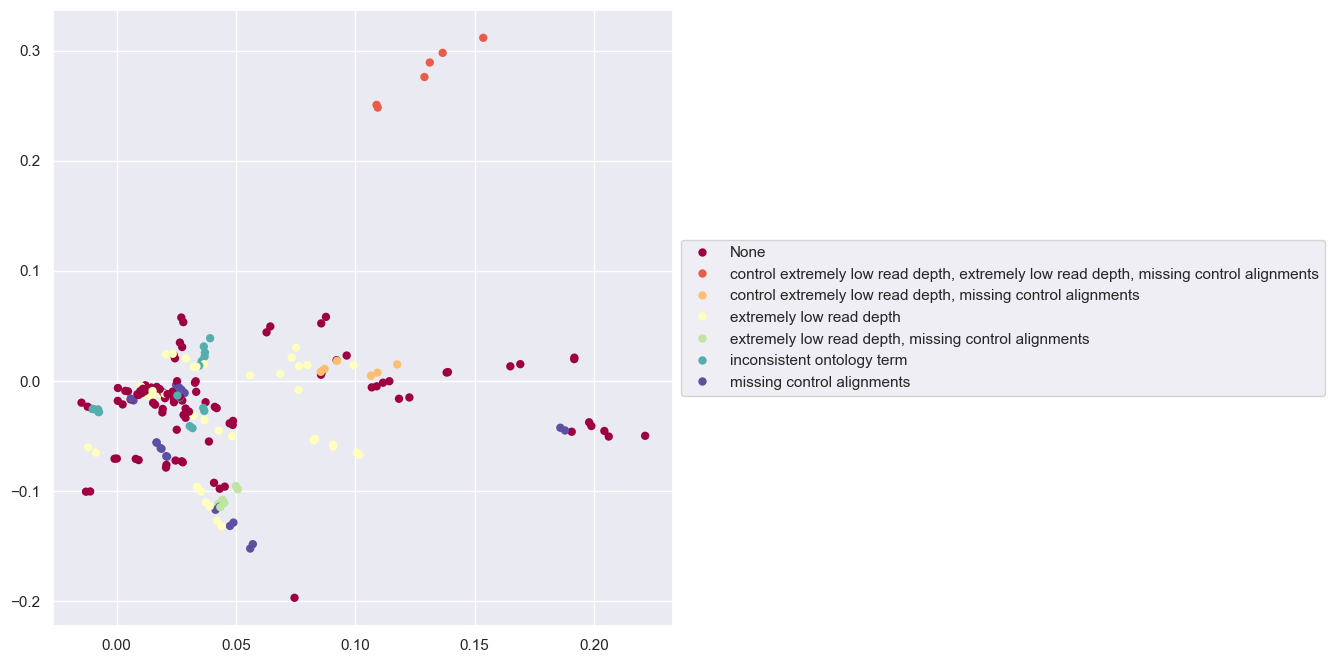

In [18]:
##Category 1 in Audit Error 
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit ERROR",alpha=1)

Based on the column "Audit Error", we actually noticed that a subset of experiments that lie in the upper right corner seem to be the only experiments to have "control extremely low read depth, extremely low read depth, missing control alignments." We decided to remove those outliers from further analysis.

We also noticed that the 200 experiments in our data all have the same output type which is fold change over control. Hence, it is not necessary to do a separate analysis between "fold change over control" and "signal p-values". 

The PCA also shows a separation between TF ChIP-seq and Histone ChIP-seq. We are going to look at those assays separately in our downstream analysis.

In [19]:
#Removing outliers based on the audit error column. Those points are the only experiment that have a PC2 component
#score higher than 0.2. 

#filter metadata and filter the df -- use those downstream (create filtered_df)
stay = [i for i,v in enumerate(pca.components_[1]) if v <= 0.2]
filtered_df = df2.iloc[:,stay]

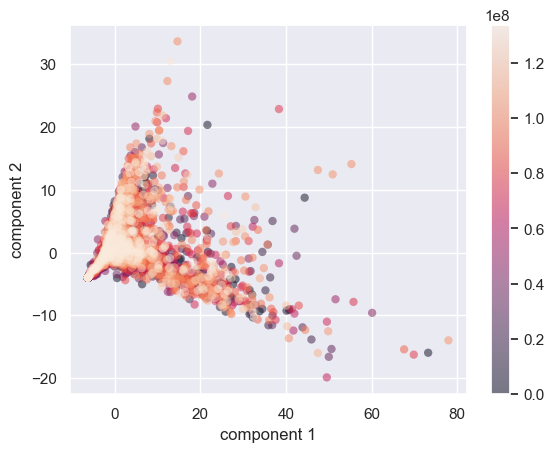

In [20]:
pca_filtered = PCA(n_components=2)
pca_filtered.fit(filtered_df)
filtered_df_pca = pca_filtered.transform(filtered_df)
plt.scatter(filtered_df_pca[:, 0], filtered_df_pca[:, 1],
            c=df.start, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

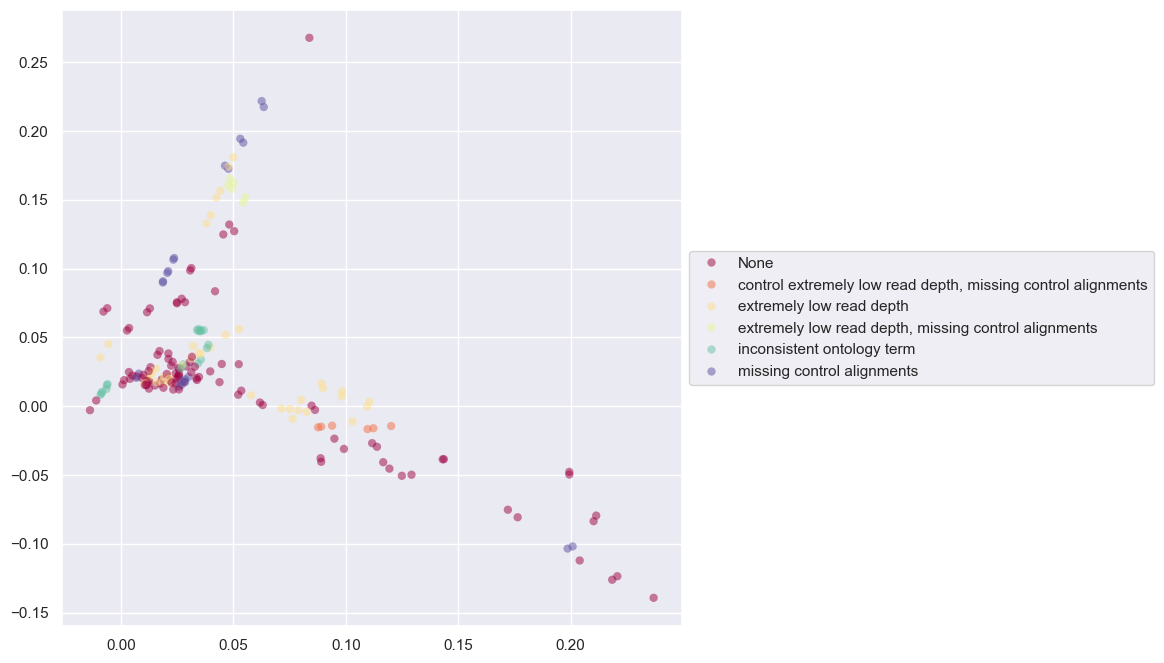

In [21]:
#validation (after)
plot_pca(pca_filtered,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit ERROR")

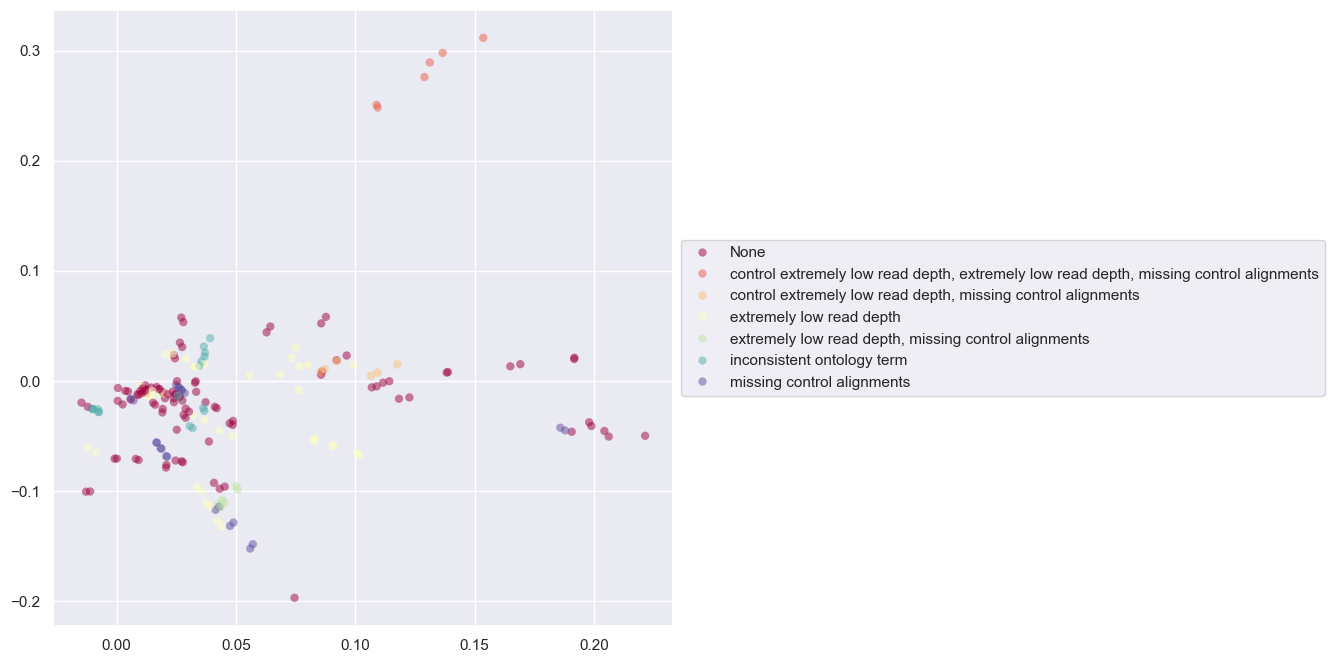

In [22]:
# (before)
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit ERROR")

### 4. Which Assays or Experiment Targets show broad vs narrow patterns with respect to genomic position? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.

Let's start with looking at the variation within the experiments when it comes to assays (TF ChIP-seq or Histone ChIP-Seq).

In [23]:
df_title = df.iloc[:,0:3]
merge_df = pd.concat([df_title, filtered_df], axis=1)

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

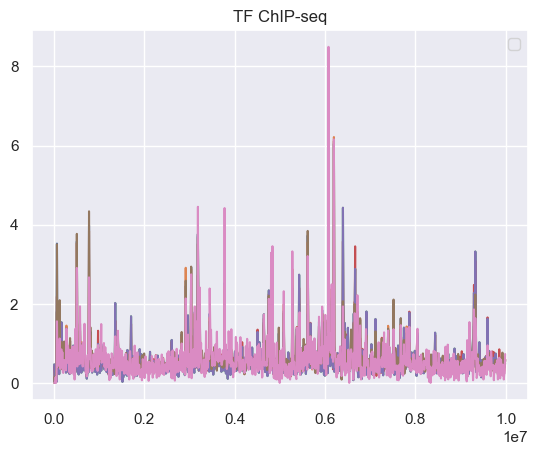

In [24]:
#This is using the assay: TF ChIP-seq
plt.plot(merge_df.start[1:1000],merge_df.ENCFF616VTY[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF911FWI[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF057LPE[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF312UWU[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF057LPE[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF953CVO[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF528ORD[1:1000])

plt.title("TF ChIP-seq")
plt.legend()
plt.show

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

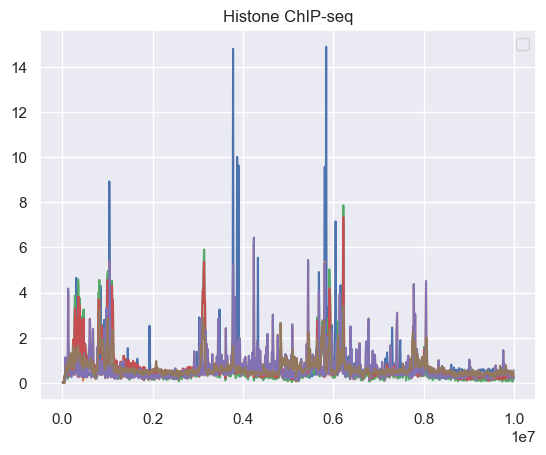

In [25]:
#This is using the assay: Histone ChIP-seq
plt.plot(merge_df.start[1:1000],merge_df.ENCFF781ZDY[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF520IHF[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF589QXD[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF037ACM[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF195GEW[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF920MFN[1:1000])

plt.title("Histone ChIP-seq")
plt.legend()
plt.show

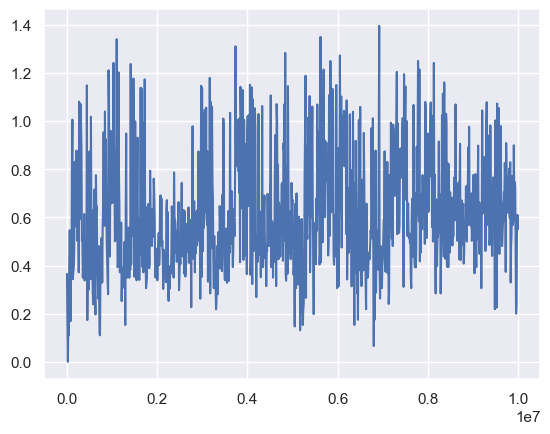

In [26]:
#ATAC-seq: ENCFF890LTR
plt.plot(merge_df.start[1:1000],merge_df.ENCFF890LTR[1:1000])

It seems that the assay "TF ChIP-seq" displays a more narrow pattern across the experiments with less variation than what we see in the assay "Histone ChIP-seq". In the histone ChIP-seq assay, there seems to be more variations across the individual experiments. This means that the histone ChIP-seq data displays more broad patterns across individual experiments.

Is this consistent across cell types? Let's try out the ChIP-seq assay first and look at fibroblast of dermis, B cells and mesenchymal stem cells.

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

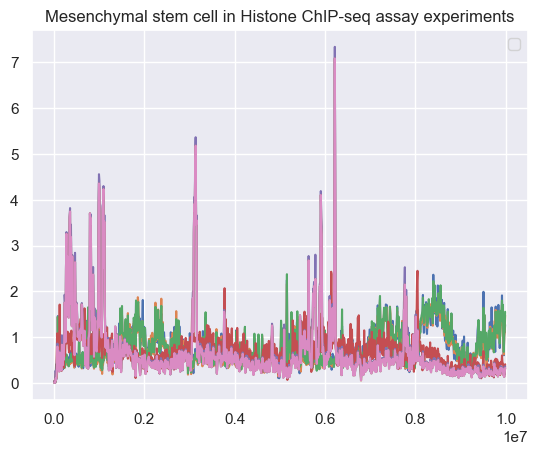

In [28]:
#This is using the assay: Histone ChIP-seq and looking at the mesenchymal stem cell type
plt.plot(merge_df.start[1:1000],merge_df.ENCFF609VYV[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF636NVM[1:1000]) 
plt.plot(merge_df.start[1:1000],merge_df.ENCFF521PSG[1:1000]) 
plt.plot(merge_df.start[1:1000],merge_df.ENCFF730DGP[1:1000]) 
plt.plot(merge_df.start[1:1000],merge_df.ENCFF037ACM[1:1000]) 
plt.plot(merge_df.start[1:1000],merge_df.ENCFF278HYJ[1:1000]) 
plt.plot(merge_df.start[1:1000],merge_df.ENCFF278HYJ[1:1000]) 


plt.title("Mesenchymal stem cell in Histone ChIP-seq assay experiments")
plt.legend()
plt.show

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

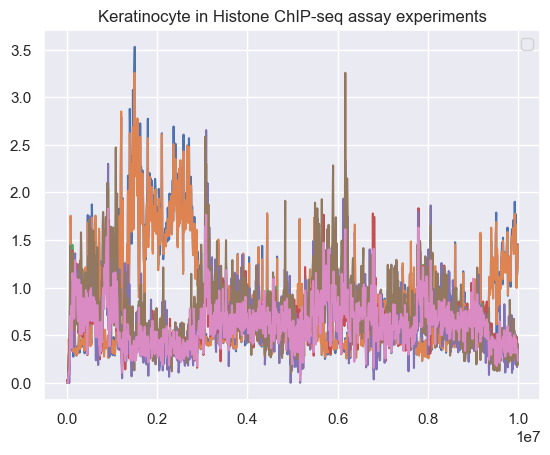

In [29]:
#This is using the assay: Histone ChIP-seq and looking at the keratinocyte cell type
plt.plot(merge_df.start[1:1000],merge_df.ENCFF251CYW[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF568EAV[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF534PKF[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF261ANP[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF528HSW[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF260LXG[1:1000])
plt.plot(merge_df.start[1:1000],merge_df.ENCFF075EYX[1:1000])

plt.title("Keratinocyte in Histone ChIP-seq assay experiments")
plt.legend()
plt.show

Is this consistent across cell types within the TF ChIP-seq assay? Let's try with fibroblast of lung and K562 and GM12878

It seems that within different cell types, the TF ChIP-seq has a narrower pattern of expression and less variant across experiments. However, the histone ChIP-seq has a broader pattern of expression and we encounter more variants across experiments within the cell types. 

In [32]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [33]:
def autocorr_name(experiment, assay, color, axes=None):
    x = merge_df[experiment].tolist()
    z = autocorr(x)

    # Evolution of the name.
    axes[0].plot(merge_df.start, x, '-o' + color,
                 label=experiment)
    axes[0].set_title("experiment1")
    axes[0].legend()

    # Autocorrelation.
    axes[1].plot(z / float(z.max()),
                 '-' + color, label=experiment)
    axes[1].legend()
    axes[1].set_title(assay)

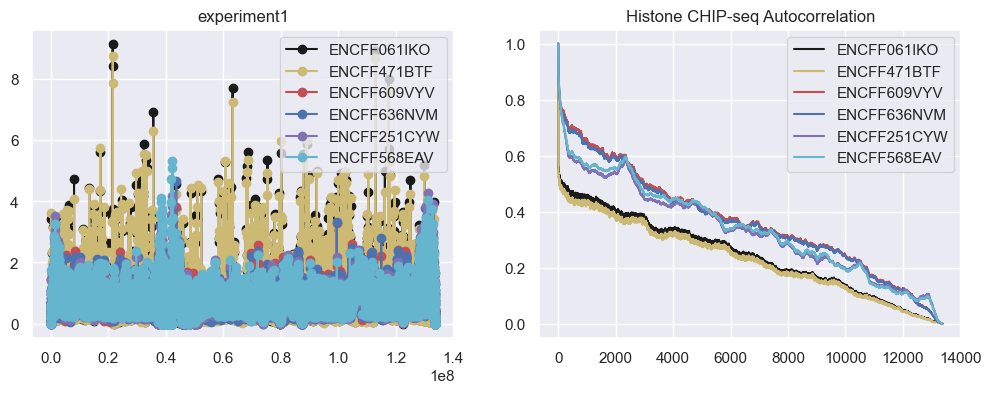

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
autocorr_name('ENCFF061IKO', 'Histone CHIP-seq Autocorrelation', 'k', axes=axes)
autocorr_name('ENCFF471BTF', 'Histone CHIP-seq Autocorrelation', 'y', axes=axes)
autocorr_name('ENCFF609VYV', 'Histone CHIP-seq Autocorrelation', 'r', axes=axes)
autocorr_name('ENCFF636NVM', 'Histone CHIP-seq Autocorrelation', 'b', axes=axes)
autocorr_name('ENCFF251CYW', 'Histone CHIP-seq Autocorrelation', 'm', axes=axes)
autocorr_name('ENCFF568EAV', 'Histone CHIP-seq Autocorrelation', 'c', axes=axes)

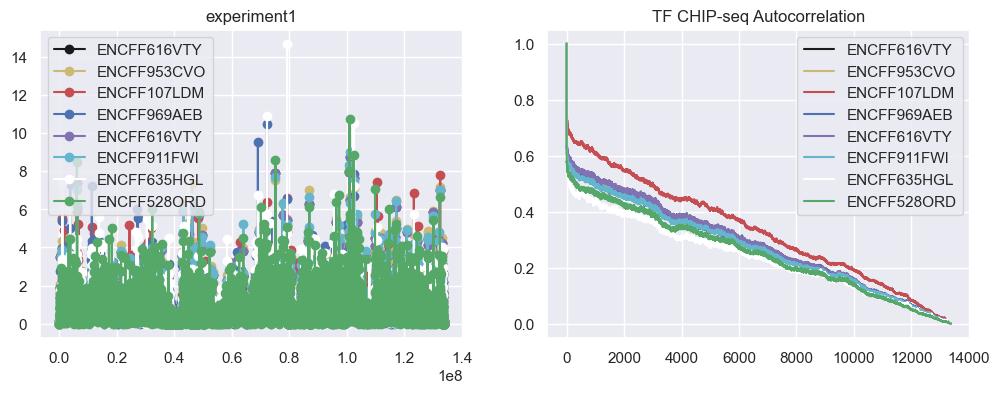

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
autocorr_name('ENCFF616VTY', 'TF CHIP-seq Autocorrelation', 'k', axes=axes)
autocorr_name('ENCFF953CVO', 'TF CHIP-seq Autocorrelation', 'y', axes=axes)
autocorr_name('ENCFF107LDM', 'TF CHIP-seq Autocorrelation', 'r', axes=axes)
autocorr_name('ENCFF969AEB', 'TF CHIP-seq Autocorrelation', 'b', axes=axes)
autocorr_name('ENCFF616VTY', 'TF CHIP-seq Autocorrelation', 'm', axes=axes)
autocorr_name('ENCFF911FWI', 'TF CHIP-seq Autocorrelation', 'c', axes=axes)
autocorr_name('ENCFF635HGL', 'TF CHIP-seq Autocorrelation', 'w', axes=axes)
autocorr_name('ENCFF528ORD', 'TF CHIP-seq Autocorrelation', 'g', axes=axes)

The autocorrelation of the TF CHIP-seq shows a narrower pattern than the autocorrelation of the Histone CHIP-seq. Within the Histone CHIP-seq, the experiments with the same cell type have similiar autocorrelations. However, the autocorrelations of different cell types vary. Within the TF CHIP-seq, the autocorrelations of different cell types do not vary that much.

In the PCA, the Histone ChIP-seq data seems to be more spreadout across the landscape than the TF ChIP-seq data that is concentrated in one area in the PCA plot (in the bottom left corner and less spread out). This confirms what we plotted above that that shows that the histone ChIP-seq data has a broader pattern than the TF ChIP-seq data.

### 5. Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.

In [36]:
filtered_df.columns
data = []
for index, row in bigwig_metadata.iterrows():
    if row['File accession'] in filtered_df.columns:
        data.append(row)
mydf = pd.DataFrame(data) #filtered metadata

In [37]:
import matplotlib.patches as mpatches

def plot_pca( pca , 
             bigwig_metadata=None,
             metadata_label_column=None, 
             cell_type=None,
             alpha=0.5, 
             lw=0, 
             figsize=(8,8)):
    
    """ 
    Skeleton for plotting PCA and annotating the plot. 
    Can be modified/extended to answer various questions.
    """
    
    
    if metadata_label_column is not None:
        if bigwig_metadata is None: 
            raise ValueError("must provide metadata table to label by a metadata column") 
        labels = [bigwig_metadata.query(
                    "`File accession`==@ file_accession ").loc[:,metadata_label_column].values[0]
                  for file_accession in pca.feature_names_in_]
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(labels)
        labels = le.transform(labels)
    else: 
        labels = None
    

    new_labels = le.inverse_transform(labels)

    my_file_accession = []
    for file_accession in pca.feature_names_in_:
        my_file_accession.append(file_accession)
    
    myindex = []
    for i in range(0,len(my_file_accession)):
        for j in range(0,len(bigwig_metadata)):
            if bigwig_metadata.iloc[j,1] == my_file_accession[i]:
                if bigwig_metadata.iloc[j,11] == cell_type:
                    myindex.append(i)
                   
    #print(myindex)
    #for i in range(0,len(bigwig_metadata)):
        #if bigwig_metadata.iloc[i,1] in my_file_accession:
            #if bigwig_metadata.iloc[i,11] == cell_type:
                #myindex.append(i)
            
    plt.figure(figsize=figsize)
    c = np.random.rand(5)
    pc1 = pca.components_[0][myindex]
    pc2 = pca.components_[1][myindex]
    mylabels = labels[myindex]
    new_labels = le.inverse_transform(mylabels)
    #print(new_labels)
    scatter = plt.scatter(pc1,
                pc2,
                c = mylabels,
                cmap = 'Spectral',
                alpha=1,
                lw=lw
   )
    plt.title(cell_type)
    classes=np.unique(new_labels).tolist()
    #print(classes)
    plt.legend(handles=scatter.legend_elements()[0],labels=classes,loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(handles=scatter.legend_elements(num=len(classes))[0], labels=classes,loc='center left', bbox_to_anchor=(1, 0.5))
#    for i, txt in enumerate(new_labels):
#        plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]))


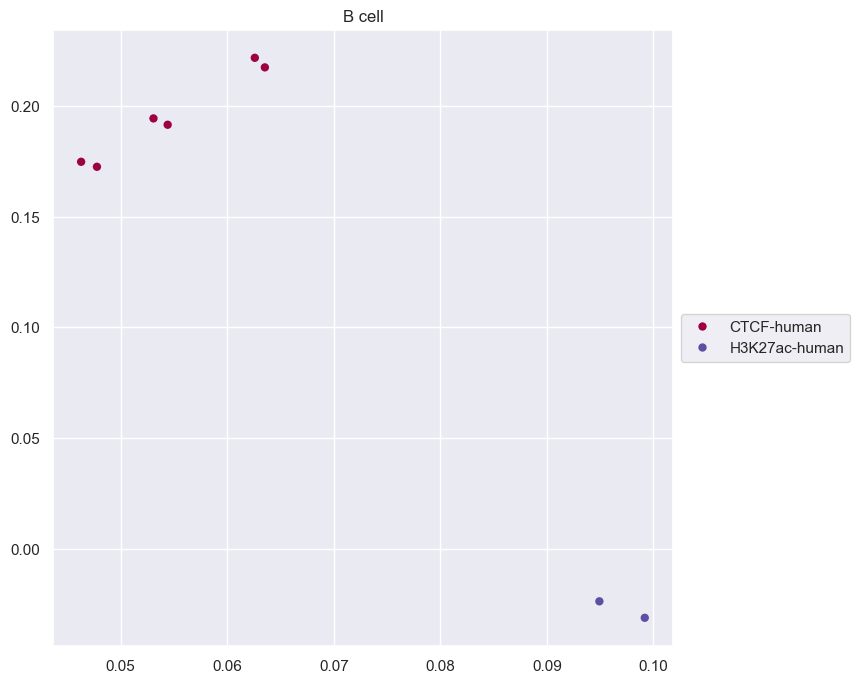

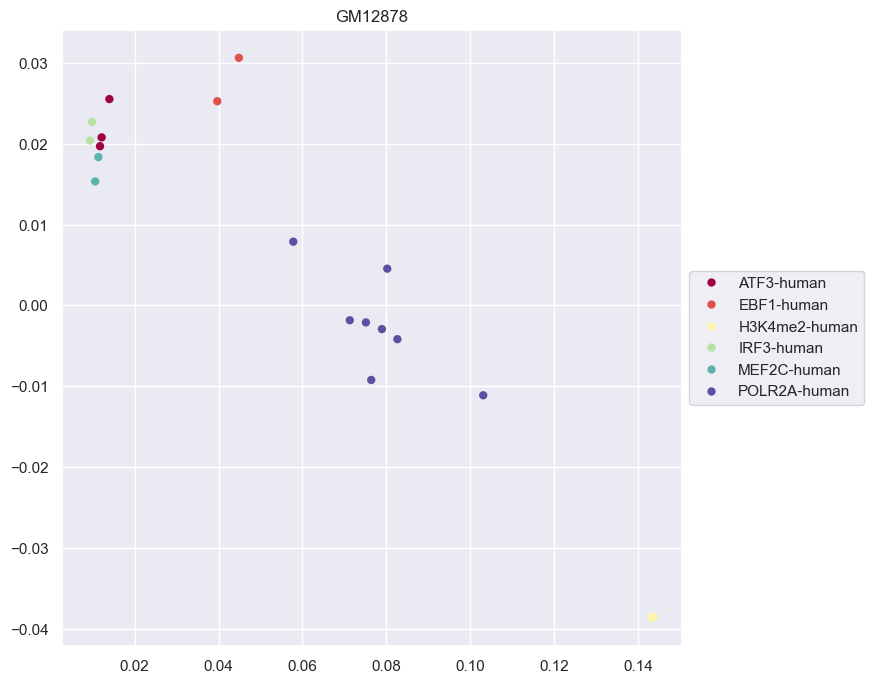

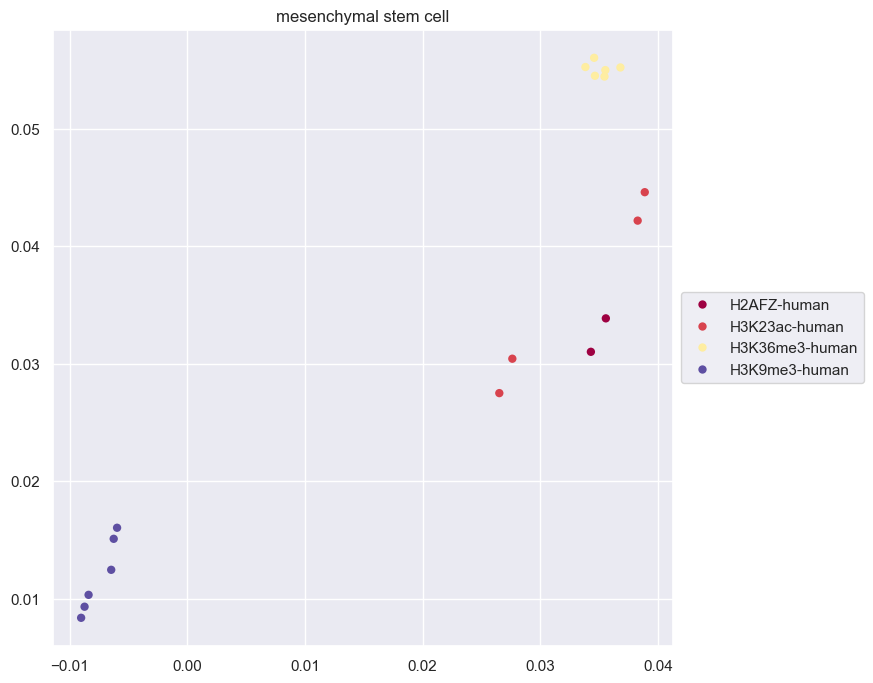

In [38]:
myplots = []
for i in ["B cell", "GM12878", "mesenchymal stem cell"]:
    myplot = plot_pca(pca_filtered,bigwig_metadata=mydf,metadata_label_column="Experiment target",cell_type=i)
    myplots.append(myplot)

From the plots above, we can see some experiment targets do cluster together in some cell types. For example, H3K9me3-human target clusters together on the mesenchymal stem cell and CTCF-human target clusters together on the B cell. Some experment targets are close together and can be interpret biologically. For instance, for the GM12878 cell type, ATF3 and MEF2C are close together on the PCA. One explanination is that MEF2C can interact with the Atf3 promoter and is capable of increasing Atf3 expression when fused to VP16. 

### 6. How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that sklearn.preprocessing.StandardScaler could be useful for preprocessing.

We should remove the region where we have a drop which is around 40 Mb (so filter the dataframe removing that row) and then normalize the data using the code below. Then, we should visualize the PCA plot again. In addition, we should create some of the plots above that were for Histone ChIP-seq and TF ChIP-seq (and also look at the autocorrelation plots.)

Text(0, 0.5, 'ENCFF230YBR')

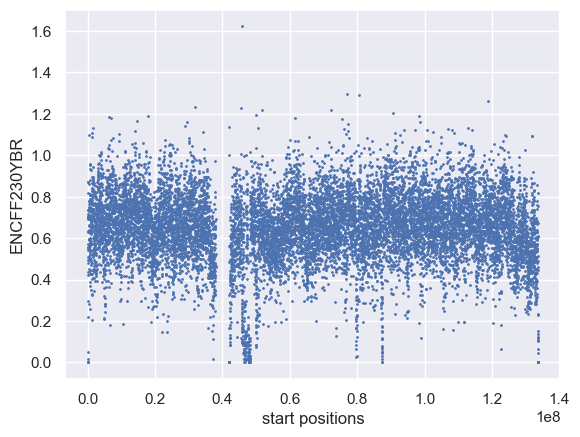

In [39]:
# remove the region around 40Mb
front = ((merge_df['start'] <= 38000000)) == True
filtered_index1 = [i for i, x in enumerate(front) if x]
back = ((merge_df['start'] >= 42000000)) == True
filtered_index2 = [i for i, x in enumerate(back) if x]
filtered_index = filtered_index1 + filtered_index2

filtered_centromere_df = df.iloc[filtered_index,:]

# validation
plt.scatter(filtered_centromere_df['start'], filtered_centromere_df['ENCFF230YBR'], s=1)
plt.xlabel('start positions')
plt.ylabel('ENCFF230YBR')

In [40]:
from sklearn.preprocessing import StandardScaler
filtered_centromere_df2 = filtered_centromere_df.drop(['chrom','start','end'],axis=1) 
scaler = StandardScaler()
scaler.fit(filtered_centromere_df2)
scaled_filtered_centromere_df = scaler.transform(filtered_centromere_df2)
scaled_filtered_centromere_df_project = scaler.fit_transform(filtered_centromere_df2)

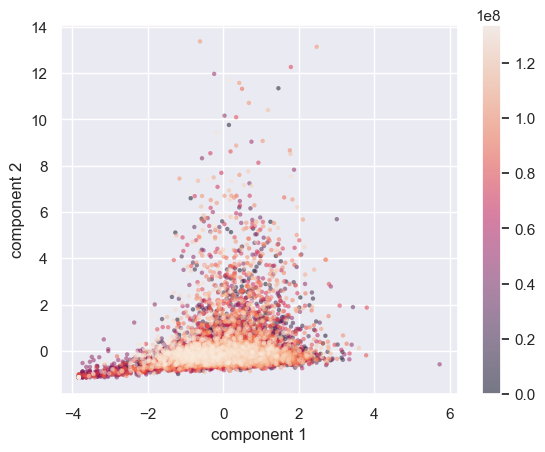

In [41]:
plt.scatter(scaled_filtered_centromere_df_project[:, 0], scaled_filtered_centromere_df_project[:, 1],
            c=filtered_centromere_df.start, edgecolor='none', alpha=0.5, s=10)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [42]:
from pandas import DataFrame
normalized_df=DataFrame(scaled_filtered_centromere_df_project)
normalized_df
pca_normalized = PCA(n_components=2)
pca_normalized.fit(normalized_df.iloc[:,:194])

PCA(n_components=2)

After we removed the 40Mb region in chr10, the PCA looks very different from before. Both the principle component 1 and the principle component 2 have smaller range in values. Also, the principle component 2 does not go below zero. Except there is a gap around the 40Mb of chr10, assays Targets vs genomic position plots stay the same. The autocorrelation plots stay the same as well.

### 7. How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot).


In [57]:
##Run PCA on the filtered data without the outliers

pca = PCA()
x=merge_df.iloc[:,3:]
x_pca = pca.fit_transform(x)

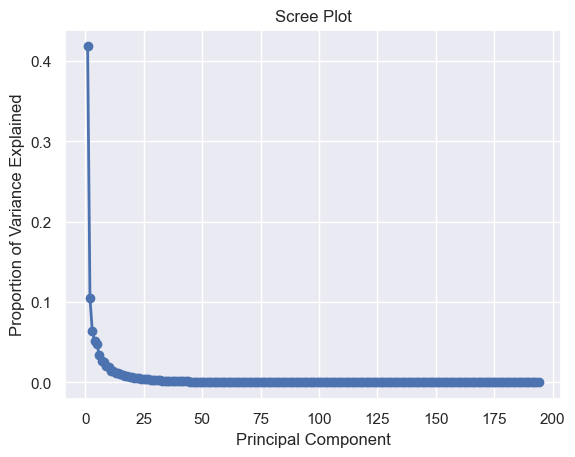

In [58]:
##Scree plot illustrates the proportion of variance explained by each of the components
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [59]:
## How many PCs explain 90% of the variance we observe in the data?
explained_variance = pca.explained_variance_ratio_
total = 0
for i in range(0,19):
    total+=explained_variance[i]
    
total

0.9020888962712358

It seems that first 19 or 20 PCs explain around 90% of the variance we observed in the data.

### 8. How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.

Since there are many genomics bins included in the data, we decided to subset into the first 5000 rows and use the first 50 experiments to be able to run MDS successfully on a smaller subset of the data. We also adjused the max_iter in MDS() to be 50, so MDS can run faster.

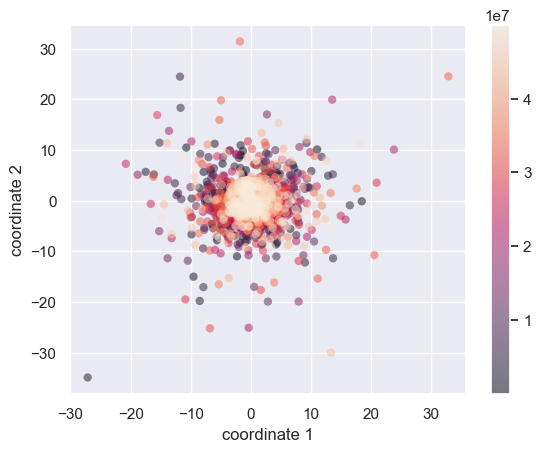

In [60]:
##Running MDS with a subset of 50 experiments.
subset_of_experiments = filtered_df.iloc[1:5000,1:51]
subset_of_experiments_with_start_and_end = pd.concat([df_title[1:5000], subset_of_experiments], axis=1)

from sklearn.datasets import load_digits
from sklearn.manifold import MDS
embedding = MDS(n_components=2,max_iter=50)
subset_of_experiments_transformed = embedding.fit_transform(subset_of_experiments)
#subset_of_experiments_transformed.shape

plt.scatter(subset_of_experiments_transformed[:, 0], subset_of_experiments_transformed[:, 1],
            c=subset_of_experiments_with_start_and_end.start, edgecolor='none', alpha=0.5)
plt.xlabel('coordinate 1')
plt.ylabel('coordinate 2')
plt.colorbar();

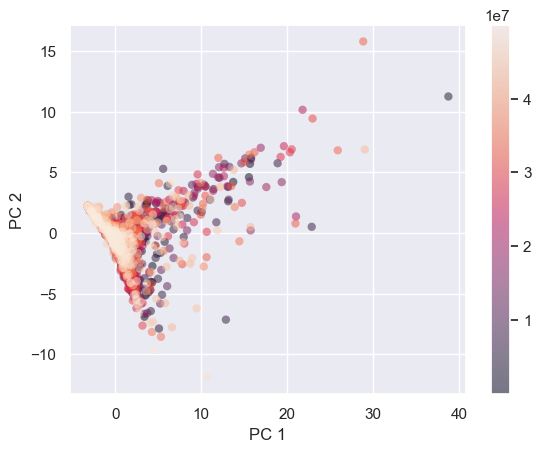

In [61]:
##Running PCA with a subset of 50 experiments
subset_of_experiments = filtered_df.iloc[1:5000,1:51]
subset_of_experiments_with_start_and_end = pd.concat([df_title[1:5000], subset_of_experiments], axis=1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(subset_of_experiments)
subset_of_experiments_pca = pca.transform(subset_of_experiments)

plt.scatter(subset_of_experiments_pca[:, 0], subset_of_experiments_pca[:, 1],
            c=subset_of_experiments_with_start_and_end.start, edgecolor='none', alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar();


Through visual inspection, the MDS plot and PCA plots look different from each other. One method we could use to explore the similarities between these methods is to compare the  distances from point i to point j in the PCA plot vs distance between points i and j in the MDS plot. We could illustrate this in a heatmap that will show us how similar/dissimilar the  distances are between the same points in PCA vs MDS. If the differences in distances are large, that means points i and j's positions are different in PCA than in MDS. This would indicate that the two dimensionality reduction methods are more similar or dissimilar. To calculate the distances, we will try out the simple measure that is euclidean distances. We could also use: Simple Matching distance or Jaccard's distance. 

In [62]:
##Calculate the euclidean distances
from sklearn.metrics.pairwise import euclidean_distances
mds_euclidean_distances  = euclidean_distances(subset_of_experiments_transformed,subset_of_experiments_transformed)
pca_euclidean_distances  = euclidean_distances(subset_of_experiments_pca,subset_of_experiments_pca)

Text(0.5, 1.0, 'Pairwise Euclidean Distances in MDS')

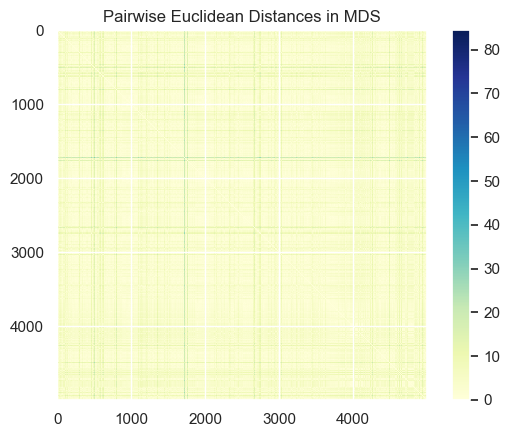

In [63]:
plt.imshow(mds_euclidean_distances,cmap='YlGnBu',interpolation='nearest')
plt.colorbar()
plt.title("Pairwise Euclidean Distances in MDS")

Text(0.5, 1.0, 'Pairwise Euclidean Distances in PCA')

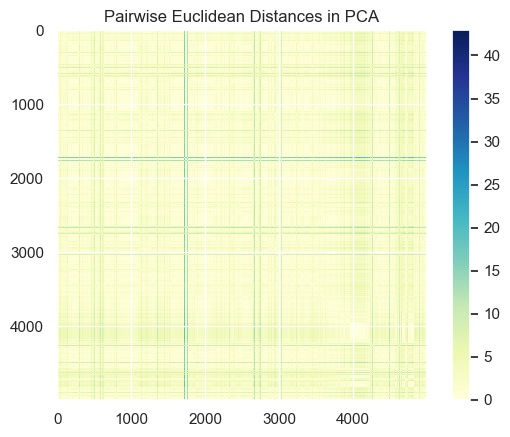

In [64]:
plt.imshow(pca_euclidean_distances,cmap='YlGnBu',interpolation='nearest')
plt.colorbar()
plt.title("Pairwise Euclidean Distances in PCA")

Text(0.5, 1.0, 'Differences Between Pairwise Euclidean Distances in PCA and MDS')

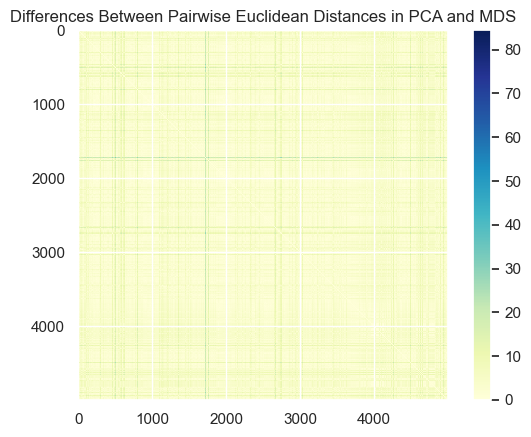

In [65]:
total = np.absolute(mds_euclidean_distances,pca_euclidean_distances)
plt.imshow(total,cmap='YlGnBu',interpolation='nearest')
plt.colorbar()
plt.title("Differences Between Pairwise Euclidean Distances in PCA and MDS")

In the last plot above, we represented the absolute values of the differences between the euclidean distance between points i and j in the MDS plot and the euclidean distance between points i and j in the PCA plot. The heatmap shows that the differences between the distances in the MDS plot and PCA plot are more minimal. This means that the MDS and PCA plots output similar positioning of the experiments.

### 9. Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not? (No plots needed for this question).

Non-negative matrix factorization (NMF) is able to discern specific features in the data we have. An example of this is in the context of facial recognition where NMF is able to produce specific features such as eyes and mouth from the photo of a face. In fact, NMF factorizes a matrix into sub-matrices that are non-neagtive. Since this form of dimensionality reduction only allows non-negative coefficients, the data is reconstructed in an additive manner. In comparison to PCA, NMF can be useful with having more interpretable transformations that make it easier to recapitulate what we see in the original data. This could be useful in the dataset we are working on in this assignment. The PCA dimensionality reduction of the experiments over the thousands of genomic bins in the data did not lead to specific patterns of experiments grouping together that could help us understand the data better. NMF could potentially help us extract specific groupings of features that we did not see in the PCA plot.

### References:

We used the following tutorial to calculate autocorrelations: https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

Question5 reference: https://www.google.com/search?q=atf3+and+mef2c&ei=lk1gY5bONLLjkPIP8-Wr6Ak&ved=0ahUKEwiW8ay_w4v7AhWyMUQIHfPyCp0Q4dUDCBE&uact=5&oq=atf3+and+mef2c&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCCEQoAEyBQghEKABMgUIIRCgAToKCAAQRxDWBBCwAzoFCAAQogQ6BwgAEB4QogRKBAhBGABKBAhGGABQ1QJYiSBgliJoAnABeACAAXuIAZgJkgEDNC43mAEAoAEByAEIwAEB&sclient=gws-wiz-serp